# SSVI Fit

This notebook fits an **SSVI** volatility surface per expiry, enforces monotone ATM total variance θ(t), runs **no‑arbitrage** diagnostics (butterfly density & calendar), interpolates **in total variance at fixed k**, optionally evaluates on TT/KK grids, and saves **params** + a **dense surface** to Parquet.


In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip -q install pyarrow

import os, json
from dataclasses import dataclass
from typing import Dict, Tuple, Optional
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from numpy import sqrt
from scipy.optimize import least_squares
from scipy.stats import norm

# Configuration
BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/VolSurf_ML"
CLEAN_PARQUET = os.path.join(BASE_DIR, "cleaned_options_data.parquet")
SCI_PARQUET   = os.path.join(BASE_DIR, "svi_metrics_today.parquet")  # optional
ALL_PARQUET   = os.path.join(BASE_DIR, "combined_options_data.parquet")   # optional (sanity only)

# Optional TT/KK market grids (evaluation only)
TT_NPY = os.path.join(BASE_DIR, "TT_grid.npy")       # time grid (years)
KK_NPY = os.path.join(BASE_DIR, "KK_grid.npy")       # k-grid (log-moneyness) OR K-grid (strikes)
IV_NPY = os.path.join(BASE_DIR, "IV_grid.npy")       # market IV grid (for comparison only)

# Outputs
OUT_DIR_SURFACE   = os.path.join(BASE_DIR, "surface")
OUT_DIR_REPORTS   = os.path.join(BASE_DIR, "reports")
OUT_DIR_ARTIFACTS = os.path.join(BASE_DIR, "artifacts")
os.makedirs(OUT_DIR_SURFACE, exist_ok=True)
os.makedirs(OUT_DIR_REPORTS, exist_ok=True)
os.makedirs(OUT_DIR_ARTIFACTS, exist_ok=True)

# As-of handling
ASOF: Optional[pd.Timestamp] = None

# Numerical tolerances
EPS_T   = 1.0/365.0     # drop maturities shorter than ~1 day
EPS_SIG = 1e-12

# Weighting
CAP_PERCENTILE = 90.0   # cap 1/spread weights at this percentile


In [3]:
def load_clean_and_metrics(clean_path: str, sci_path: Optional[str] = None) -> pd.DataFrame:
    df = pd.read_parquet(clean_path)

    # normalize column names: lower + underscores
    df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

    if 'expiry' in df.columns:
        df['expiry_dt'] = pd.to_datetime(df['expiry'], errors='coerce')
    elif 'expiration' in df.columns:
        df['expiry_dt'] = pd.to_datetime(df['expiration'], errors='coerce')
    else:
        raise ValueError("Missing expiry/expiration column")

    # option type -> cp_flag in {'C','P'}
    if 'type' not in df.columns:
        raise ValueError("Missing 'type' column for call/put")
    df['cp_flag'] = df['type'].astype(str).str.upper().str[0].map({'C':'C','P':'P'})

    # numeric fields
    for col in ['strike','bid','ask','mid','spread','last_price']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # spot & T
    if 's' in df.columns:
        df['S'] = pd.to_numeric(df['s'], errors='coerce')
    else:
        raise ValueError("Missing 'S' (spot) column")

    if 't' in df.columns:
        df['T'] = pd.to_numeric(df['t'], errors='coerce')
    else:
        df['T'] = np.nan

    # IV — prefer iv_clean; else implied_volatility (decimal); else iv_% / 100
    if 'iv_clean' in df.columns:
        df['mid_iv'] = pd.to_numeric(df['iv_clean'], errors='coerce')
    elif 'implied_volatility' in df.columns:
        df['mid_iv'] = pd.to_numeric(df['implied_volatility'], errors='coerce')
    elif 'iv_%' in df.columns:
        df['mid_iv'] = pd.to_numeric(df['iv_%'], errors='coerce')/100.0
    else:
        raise ValueError("No volatility column found (iv_clean / implied_volatility / iv_%)")


    keep = ['expiry_dt','cp_flag','strike','S','T','mid_iv','bid','ask','mid','spread','openinterest','volume','k']
    keep = [c for c in keep if c in df.columns]
    df = df[keep].copy()
    df.rename(columns={'strike':'K','openinterest':'oi'}, inplace=True)


    return df

def infer_asof(df: pd.DataFrame) -> pd.Timestamp:
    return pd.Timestamp.today().normalize()

# Load
SSVI_DF = load_clean_and_metrics(CLEAN_PARQUET, SCI_PARQUET if os.path.exists(SCI_PARQUET) else None)

# Infer ASOF if not set
if ASOF is None:
    ASOF = infer_asof(SSVI_DF)

# Compute T if missing
mask_T_missing = SSVI_DF['T'].isna()
if mask_T_missing.any():
    SSVI_DF.loc[:, 'T'] = (SSVI_DF['expiry_dt'] - ASOF).dt.days / 365.25

# Filter to future expiries and drop ultra-short
SSVI_DF = SSVI_DF[ SSVI_DF['T'] > EPS_T ].copy()

# Basic IV sanity
SSVI_DF = SSVI_DF[(SSVI_DF['mid_iv'] > 0) & (SSVI_DF['mid_iv'] < 3.0)].copy()



In [4]:
# Guarantee mid/spread on the loaded SSVI_DF
for c in ('bid','ask','mid','spread'):
    if c in SSVI_DF.columns:
        SSVI_DF[c] = pd.to_numeric(SSVI_DF[c], errors='coerce')

if ('mid' not in SSVI_DF.columns) or SSVI_DF['mid'].isna().any():
    if {'bid','ask'}.issubset(SSVI_DF.columns):
        SSVI_DF['mid'] = (SSVI_DF['ask'] + SSVI_DF['bid']) / 2.0
    else:
        SSVI_DF['mid'] = np.nan

if ('spread' not in SSVI_DF.columns) or SSVI_DF['spread'].isna().any():
    if {'bid','ask'}.issubset(SSVI_DF.columns):
        SSVI_DF['spread'] = (SSVI_DF['ask'] - SSVI_DF['bid']).clip(lower=1e-6)
    else:
        SSVI_DF['spread'] = 1.0

In [5]:
def infer_forward_by_parity(expiry_slice: pd.DataFrame, atm_band: float = 0.07) -> float:
    """Infer F_t from paired C/P at same K using parity: F ≈ K + (C - P).
    Restrict to ATM band to reduce noise; fallback to median(S) if pairs are thin."""
    g = expiry_slice.copy()
    S_med = float(np.nanmedian(g['S']))
    atm_mask = (g['K'] >= 0.7*S_med) & (g['K'] <= 1.3*S_med)
    g = g.loc[atm_mask]
    piv = g.pivot_table(index='K', columns='cp_flag', values='mid', aggfunc='median')
    piv = piv.dropna(how='any')
    if len(piv) >= 2:
        C = piv['C'] if 'C' in piv.columns else None
        P = piv['P'] if 'P' in piv.columns else None
        if C is not None and P is not None:
            F_candidates = (C - P) + piv.index.values
            F_hat = float(np.nanmedian(F_candidates))
            if np.isfinite(F_hat) and F_hat > 0:
                return F_hat
    return float(S_med)

def estimate_theta_atm(expiry_slice: pd.DataFrame, F: float) -> float:
    """θ = (σ_ATM)^2 * T using the quote whose K is closest to F."""
    g = expiry_slice.copy()
    idx = (g['K'] - F).abs().idxmin()
    sigma_atm = float(g.loc[idx, 'mid_iv'])
    T = float(g.loc[idx, 'T'])
    return max(sigma_atm, EPS_SIG)**2 * max(T, EPS_SIG)

# Group by expiry, infer F and θ
by_exp: Dict[pd.Timestamp, pd.DataFrame] = dict(tuple(SSVI_DF.groupby('expiry_dt', sort=True)))
forwards: Dict[pd.Timestamp, float] = {}
thetas: Dict[pd.Timestamp, float] = {}
for exp, g in by_exp.items():
    F_t = infer_forward_by_parity(g)
    forwards[exp] = F_t
    thetas[exp] = estimate_theta_atm(g, F_t)

# Monotone θ(t) to reduce calendar arb
exps_sorted = sorted(thetas, key=lambda e: (e - ASOF).days)
theta_arr = np.array([thetas[e] for e in exps_sorted])
theta_mono = np.maximum.accumulate(theta_arr)
thetas = {e: th for e, th in zip(exps_sorted, theta_mono)}

# forward-based log-moneyness per row
SSVI_DF['F'] = SSVI_DF['expiry_dt'].map(forwards)
# guard against NaNs/zeros
valid_F = SSVI_DF['F'].replace([0, np.inf, -np.inf], np.nan).notna()
SSVI_DF['k_fwd'] = np.nan
SSVI_DF.loc[valid_F, 'k_fwd'] = np.log(SSVI_DF.loc[valid_F, 'K'] / SSVI_DF.loc[valid_F, 'F'])
# fallback if some rows still NaN: use provided 'k' (may be vs spot) or 0.0
if 'k' in SSVI_DF.columns:
    SSVI_DF['k_fwd'] = SSVI_DF['k_fwd'].fillna(SSVI_DF['k'])
SSVI_DF['k_fwd'] = SSVI_DF['k_fwd'].fillna(0.0)
by_exp = {e: g.copy() for e, g in SSVI_DF.groupby('expiry_dt', sort=True)}

In [6]:
if 'k_fwd' not in SSVI_DF.columns:
  print("Warning: k_fwd not set yet")
def build_weights(df: pd.DataFrame, cap_percentile: float = 90.0) -> np.ndarray:
    # Primary: inverse spread (capped)
    spread = df['spread'] if 'spread' in df.columns else None
    if spread is None or spread.isna().all():
        spread = (df['ask'] - df['bid']) if {'ask','bid'}.issubset(df.columns) else pd.Series(1.0, index=df.index)
    spread = spread.replace([np.inf, -np.inf], np.nan).fillna(1.0).clip(lower=1e-6)
    w = 1.0 / spread
    cap = np.nanpercentile(w, cap_percentile)
    w = np.minimum(w, cap)

    # Liquidity bumps
    if 'oi' in df.columns:
        w *= (1.0 + 0.5 * df['oi'].rank(pct=True).fillna(0.0))
    if 'volume' in df.columns:
        w *= (1.0 + 0.25 * df['volume'].rank(pct=True).fillna(0.0))

    # Down-weight extreme |k|
    if 'k_fwd' in df.columns:
        k_abs = df['k_fwd'].abs()
    elif 'k' in df.columns:
        k_abs = df['k'].abs()
    else:
        k_abs = pd.Series(0.0, index=df.index)
    k_cut = np.nanpercentile(k_abs, 99.0)
    w *= (1.0 - 0.5 * (k_abs > k_cut))

    return w.values

SSVI_DF['w_mkt'] = (SSVI_DF['mid_iv']**2) * SSVI_DF['T']
SSVI_DF['wgt']   = build_weights(SSVI_DF)
by_exp = {e: g.copy() for e, g in SSVI_DF.groupby('expiry_dt', sort=True)}


In [7]:
@dataclass
class SSVIParams:
    rho: float
    eta: float
    p:   float

def phi(theta: float, eta: float, p: float) -> float:
    return eta * (theta ** (-p))

def w_ssvi(k: np.ndarray, theta: float, rho: float, eta: float, p: float) -> np.ndarray:
    ph = phi(theta, eta, p)
    root = np.sqrt((ph*k + rho)**2 + (1.0 - rho**2))
    return 0.5 * theta * (1.0 + rho*ph*k + root)

def fit_slice_ssvi(k: np.ndarray, w_mkt: np.ndarray, theta: float, wgt: Optional[np.ndarray] = None,
                   seed: SSVIParams = SSVIParams(rho=-0.2, eta=0.5, p=0.5)) -> Tuple[SSVIParams, float]:
    k = np.asarray(k, float)
    w_mkt = np.asarray(w_mkt, float)
    wgt = np.ones_like(w_mkt) if wgt is None else np.asarray(wgt, float)
    x0 = np.array([seed.rho, seed.eta, seed.p], float)
    lb = np.array([-0.999, 1e-6, 0.0], float)
    ub = np.array([ 0.999, 5.0,   1.0], float)
    def resid(x):
        rho, eta, p = x
        w_model = w_ssvi(k, theta, rho, eta, p)
        err = (w_model - w_mkt)
        # light regularisation to discourage pathological wings
        pen = 1e-4 * (np.maximum(np.abs(k) - 3.0, 0.0)**2).mean() * (eta**2)
        return np.sqrt(wgt) * err + pen
    out = least_squares(resid, x0, bounds=(lb, ub), max_nfev=2000)
    rho, eta, p = out.x
    return SSVIParams(float(rho), float(eta), float(p)), float(out.cost)

# Fit per expiry slice
slice_params: Dict[pd.Timestamp, Tuple[SSVIParams, float]] = {}
for exp, g in by_exp.items():
    g = g[g['T'] > EPS_T].copy()
    theta = float(thetas[exp])
    k = g['k_fwd'].values
    w = g['w_mkt'].values
    wgt = build_weights(g)
    params, cost = fit_slice_ssvi(k, w, theta, wgt)
    slice_params[exp] = (params, cost)


In [8]:
def black_call_from_fwd(F: float, K: float, T: float, sigma: float, df: float = 1.0) -> float:
    if sigma <= 0 or T <= 0:
        return df * max(F - K, 0.0)
    vol = sigma * sqrt(T)
    if vol < 1e-12:
        return df * max(F - K, 0.0)
    d1 = (np.log(F/K) + 0.5*vol*vol) / vol
    d2 = d1 - vol
    return df * (F*norm.cdf(d1) - K*norm.cdf(d2))

def density_min_for_slice(expiry: pd.Timestamp, params: SSVIParams, theta: float, r: float = 0.0):
    F = forwards[expiry]
    T = max(((expiry - ASOF).days / 365.25), EPS_T)
    K = np.geomspace(F*0.5, F*1.5, 301)
    k = np.log(K/F)
    w = w_ssvi(k, theta, params.rho, params.eta, params.p)
    sigma = np.sqrt(np.maximum(w, EPS_SIG) / T)
    C = np.array([black_call_from_fwd(F, Kv, T, sv, df=np.exp(-r*T)) for Kv, sv in zip(K, sigma)])
    d1 = np.gradient(C, K)
    d2 = np.gradient(d1, K)
    q = np.exp(r*T) * d2
    return float(np.nanmin(q)), K, q

# Butterfly check per slice
butterfly_report = []
for exp, (par, _) in slice_params.items():
    qmin, _, _ = density_min_for_slice(exp, par, thetas[exp], r=0.0)
    butterfly_report.append(dict(expiry=exp, qmin=qmin))
butterfly_df = pd.DataFrame(butterfly_report).sort_values('expiry')

# Calendar check across adjacent maturities
calendar_report = []
exps = sorted(slice_params)
for i in range(len(exps)-1):
    e0, e1 = exps[i], exps[i+1]
    F0, F1 = forwards[e0], forwards[e1]
    T0 = max(((e0 - ASOF).days / 365.25), EPS_T)
    T1 = max(((e1 - ASOF).days / 365.25), EPS_T)
    K = np.geomspace(min(F0, F1)*0.6, max(F0, F1)*1.6, 121)
    k0 = np.log(K / F0)
    w0 = w_ssvi(k0, thetas[e0], slice_params[e0][0].rho, slice_params[e0][0].eta, slice_params[e0][0].p)
    s0 = np.sqrt(np.maximum(w0, EPS_SIG) / T0)
    C0 = np.array([black_call_from_fwd(F0, Kv, T0, sv) for Kv, sv in zip(K, s0)])
    k1 = np.log(K / F1)
    w1 = w_ssvi(k1, thetas[e1], slice_params[e1][0].rho, slice_params[e1][0].eta, slice_params[e1][0].p)
    s1 = np.sqrt(np.maximum(w1, EPS_SIG) / T1)
    C1 = np.array([black_call_from_fwd(F1, Kv, T1, sv) for Kv, sv in zip(K, s1)])
    viol = int((C1 < C0 - 1e-6).sum())
    calendar_report.append(dict(expiry0=e0, expiry1=e1, violations=viol))
calendar_df  = pd.DataFrame(calendar_report)


In [9]:
k_grid = np.linspace(-3.0, 3.0, 121)
exps_sorted = sorted(slice_params)
t_knots = np.array([max(((e - ASOF).days / 365.25), EPS_T) for e in exps_sorted])
W_knots = np.stack([
    w_ssvi(k_grid, thetas[e], slice_params[e][0].rho, slice_params[e][0].eta, slice_params[e][0].p)
    for e in exps_sorted
], axis=0)  # shape (T, K)

def w_interpolated(t_query: float, k_query: np.ndarray) -> np.ndarray:
    t = float(t_query)
    if t <= t_knots[0]:
        return np.interp(k_query, k_grid, W_knots[0])
    if t >= t_knots[-1]:
        return np.interp(k_query, k_grid, W_knots[-1])
    j = int(np.searchsorted(t_knots, t) - 1)
    w0 = np.interp(k_query, k_grid, W_knots[j])
    w1 = np.interp(k_query, k_grid, W_knots[j+1])
    t0, t1 = t_knots[j], t_knots[j+1]
    a = (t - t0) / (t1 - t0)
    return (1.0 - a) * w0 + a * w1

#evaluate on TT/KK grids (if they exist and KK is k-grid)
# Normalize TT / KK to 1-D vectors (handles meshgrid or vectors)
def to_vectors(TT, KK):
    TT = np.asarray(TT)
    KK = np.asarray(KK)

    if TT.ndim == 2 and KK.ndim == 2 and TT.shape == KK.shape:
        return TT[:, 0], KK[0, :]

    if TT.ndim == 1 and KK.ndim == 1:
        return TT, KK
    if TT.ndim == 2:
        TT = TT[:, 0]
    if KK.ndim == 2:
        KK = KK[0, :]
    return TT.ravel(), KK.ravel()

# Load grids
TT = np.load(TT_NPY)
KK = np.load(KK_NPY)


TT_vec, KK_vec = to_vectors(TT, KK)

# Evaluate model on the TT × KK lattice
SIG = np.zeros((len(TT_vec), len(KK_vec)))
for i, t in enumerate(TT_vec):
    w_row = w_interpolated(float(t), KK_vec)
    SIG[i, :] = np.sqrt(np.maximum(w_row, EPS_SIG) / max(t, EPS_T))

np.savez(os.path.join(OUT_DIR_ARTIFACTS, f"ssvi_model_grid_{ASOF.date()}.npz"),
         TT=TT_vec, KK=KK_vec, SIG=SIG)

In [14]:
params_rows = []
for e in exps_sorted:
    par, cost = slice_params[e]
    params_rows.append(dict(
        asof=ASOF,
        expiry=e,
        T=max(((e - ASOF).days / 365.25), EPS_T),
        theta=thetas[e],
        rho=par.rho,
        eta=par.eta,
        p=par.p,
        fit_cost=cost
    ))
params_df = pd.DataFrame(params_rows).sort_values('T')
# Make SSVI parameter names explicit
params_df = params_df.rename(columns={
    'rho': 'ssvi_rho',
    'eta': 'ssvi_eta',
    'p':   'ssvi_p',
})
params_df = params_df.merge(butterfly_df.rename(columns={'expiry':'expiry'}), on='expiry', how='left')
if not calendar_df.empty:
    cal_summary = calendar_df.groupby('expiry0', as_index=False)['violations'].max().rename(columns={'expiry0':'expiry','violations':'calendar_violations'})
    params_df = params_df.merge(cal_summary, on='expiry', how='left')

params_path = os.path.join(OUT_DIR_SURFACE, f"ssvi_params_{ASOF.date()}.parquet")
params_df.to_parquet(params_path, index=False)

t_dense = np.linspace(t_knots.min(), t_knots.max(), 50)
rows = []
for t in t_dense:
    w_row = w_interpolated(float(t), k_grid)
    sig_row = np.sqrt(np.maximum(w_row, EPS_SIG) / max(t, EPS_T))
    for ki, wi, si in zip(k_grid, w_row, sig_row):
        rows.append((ASOF, t, ki, wi, si))
surface_df = pd.DataFrame(rows, columns=['asof','t','k','w','sigma'])
surface_path = os.path.join(OUT_DIR_SURFACE, f"ssvi_surface_{ASOF.date()}.parquet")
surface_df.to_parquet(surface_path, index=False)

report = {
    "asof": str(ASOF.date()),
    "slices": int(len(exps_sorted)),
    "params_path": params_path,
    "surface_path": surface_path,
    "min_density_per_slice": butterfly_df.sort_values('expiry').to_dict(orient='records'),
    "calendar_pairs": calendar_df.to_dict(orient='records') if not calendar_df.empty else []
}
with open(os.path.join(OUT_DIR_REPORTS, f"ssvi_report_{ASOF.date()}.json"), "w") as f:
    json.dump(report, f, indent=2, default=str)

print("Saved:")
print("  ", params_path)
print("  ", surface_path)
print("  ", os.path.join(OUT_DIR_REPORTS, f"ssvi_report_{ASOF.date()}.json"))

# export compact SSVI metrics for ML
METRICS_DIR = "/content/drive/MyDrive/Colab Notebooks/VolSurf_ML/metrics"
os.makedirs(METRICS_DIR, exist_ok=True)

# Keep only the columns for ML
ssvi_metrics = params_df[[
    'asof',
    'expiry',
    'T',
    'theta',        # ATM total variance
    'ssvi_rho',
    'ssvi_eta',
    'ssvi_p',
    'fit_cost',
    'calendar_violations',   # if present from the merges above
]].copy()

ssvi_metrics_path = os.path.join(METRICS_DIR, f"ssvi_metrics_{ASOF.date()}.parquet")
ssvi_metrics.to_parquet(ssvi_metrics_path, index=False)
print("Saved SSVI metrics to", ssvi_metrics_path)



Saved:
   /content/drive/MyDrive/Colab Notebooks/VolSurf_ML/surface/ssvi_params_2025-11-15.parquet
   /content/drive/MyDrive/Colab Notebooks/VolSurf_ML/surface/ssvi_surface_2025-11-15.parquet
   /content/drive/MyDrive/Colab Notebooks/VolSurf_ML/reports/ssvi_report_2025-11-15.json
Saved SSVI metrics to /content/drive/MyDrive/Colab Notebooks/VolSurf_ML/metrics/ssvi_metrics_2025-11-15.parquet


In [11]:
print("Slices:", len(exps_sorted))
print("Theta monotone?", np.all(np.diff(params_df['theta'].values) >= -1e-12))
print("Min q per slice (first 5):", butterfly_df.sort_values('expiry').head().to_dict(orient='records'))
print("Calendar violation pairs (first 5):", calendar_df.head().to_dict(orient='records') if not calendar_df.empty else [])


Slices: 20
Theta monotone? True
Min q per slice (first 5): [{'expiry': Timestamp('2025-11-21 00:00:00'), 'qmin': -0.0001510245051957182}, {'expiry': Timestamp('2025-11-28 00:00:00'), 'qmin': 5.824876617257136e-07}, {'expiry': Timestamp('2025-12-05 00:00:00'), 'qmin': 1.8091424679210433e-06}, {'expiry': Timestamp('2025-12-12 00:00:00'), 'qmin': 4.29986627491852e-07}, {'expiry': Timestamp('2025-12-19 00:00:00'), 'qmin': 2.1502887430234907e-05}]
Calendar violation pairs (first 5): [{'expiry0': Timestamp('2025-11-21 00:00:00'), 'expiry1': Timestamp('2025-11-28 00:00:00'), 'violations': 101}, {'expiry0': Timestamp('2025-11-28 00:00:00'), 'expiry1': Timestamp('2025-12-05 00:00:00'), 'violations': 0}, {'expiry0': Timestamp('2025-12-05 00:00:00'), 'expiry1': Timestamp('2025-12-12 00:00:00'), 'violations': 42}, {'expiry0': Timestamp('2025-12-12 00:00:00'), 'expiry1': Timestamp('2025-12-19 00:00:00'), 'violations': 0}, {'expiry0': Timestamp('2025-12-19 00:00:00'), 'expiry1': Timestamp('2025-12-2

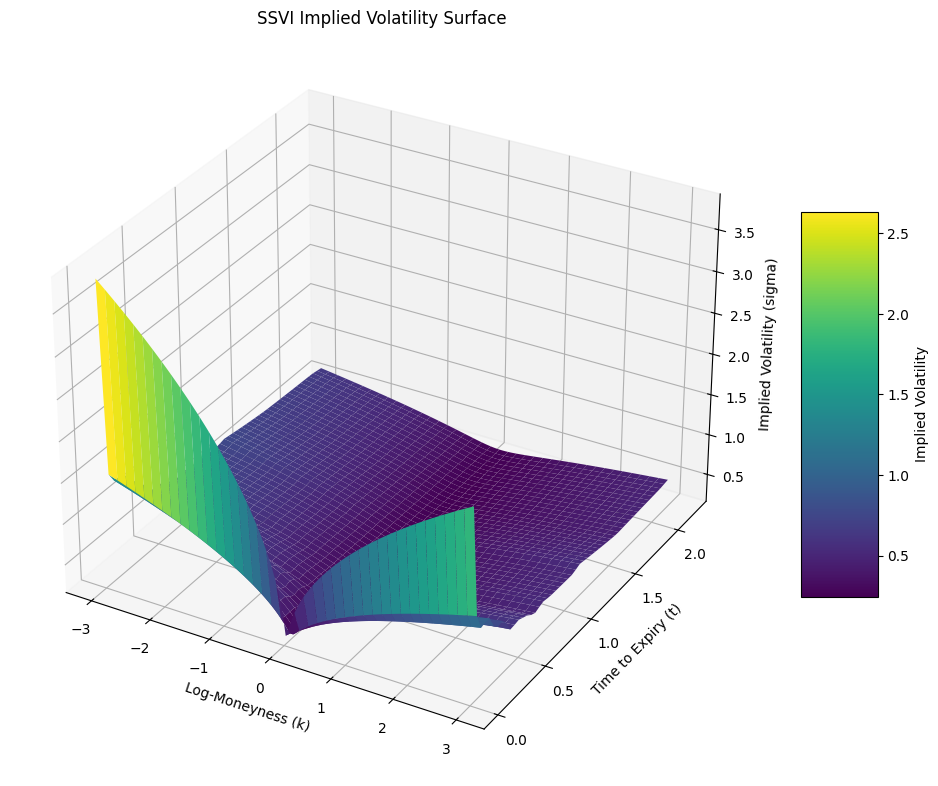

In [12]:
# Extract data from surface_df
T = surface_df['t'].values
K = surface_df['k'].values
SIGMA = surface_df['sigma'].values

# Prepare data for 3D plot
unique_t = np.sort(surface_df['t'].unique())
unique_k = np.sort(surface_df['k'].unique())

# Create a meshgrid for the plot
T_grid, K_grid = np.meshgrid(unique_t, unique_k)

# Create a 2D array for sigma, filling it based on the surface_df
SIGMA_grid = np.zeros_like(T_grid, dtype=float)

for i, t_val in enumerate(unique_t):
    for j, k_val in enumerate(unique_k):
        # Find the corresponding sigma value in surface_df
        sigma_val = surface_df[(surface_df['t'] == t_val) & (surface_df['k'] == k_val)]['sigma'].iloc[0]
        SIGMA_grid[j, i] = sigma_val

# Create the 3D plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(K_grid, T_grid, SIGMA_grid, cmap='viridis', edgecolor='none')

# Add labels and title
ax.set_xlabel('Log-Moneyness (k)')
ax.set_ylabel('Time to Expiry (t)')
ax.set_zlabel('Implied Volatility (sigma)')
ax.set_title('SSVI Implied Volatility Surface')

# Add a color bar which maps values to colors
fig.colorbar(surf, shrink=0.5, aspect=5, label='Implied Volatility')

plt.show()